In [ ]:
from google.colab import drive
drive.mount('/content/drive')

zip_path = "/content/drive/MyDrive/yenidataset_split.zip"

dest_dir = "/content/yenidataset_split3"

import zipfile
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(dest_dir)

print(f"✅ {zip_path} içeriği {dest_dir} klasörüne çıkarıldı.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ /content/drive/MyDrive/yenidataset_split.zip içeriği /content/yenidataset_split3 klasörüne çıkarıldı.


In [ ]:
import os
import time
import random
import numpy as np
import torch
import torch.nn as nn
import timm

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


In [ ]:
# ─── 1️⃣ CONFIG ────────────────────────────────────────────────────────────────
EPOCHS       = 20
BATCH_SIZE   = 64
IMG_SIZE     = 224
NUM_CLASSES  = 5
DATA_PATH    = "/content/yenidataset_split3/yenidataset_split"
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED         = 42
PATIENCE     = 6
LR           = 1e-5
WEIGHT_DECAY = 5e-3
# ────────────────────────────────────────────────────────────────────────────────

# Reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if DEVICE.type == 'cuda':
    torch.cuda.manual_seed(SEED)

In [ ]:
# ─── 2️⃣ TRANSFORMS ─────────────────────────────────────────────────────────────

mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2,0.2,0.2,0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


In [ ]:
# ─── 3️⃣ DATASETS & DATALOADERS ───────────────────────────────────────────────
train_ds = ImageFolder(os.path.join(DATA_PATH, "train"), transform=train_transform)
val_ds   = ImageFolder(os.path.join(DATA_PATH, "val"),   transform=val_transform)
test_ds  = ImageFolder(os.path.join(DATA_PATH, "test"),  transform=test_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=2, pin_memory=True)


In [ ]:
# ─── 4️⃣ MODEL, LOSS, OPTIMIZER & SCHEDULER ─────────────────────────────────────
model = timm.create_model(
    'swin_tiny_patch4_window7_224',
    pretrained=True,
    num_classes=NUM_CLASSES,
    drop_rate=0.5
).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, verbose=True
)


In [ ]:
# ─── 5️⃣ TRAIN + VALIDATION + EARLY STOPPING ───────────────────────────────────
best_val_loss = float('inf')
patience_cnt  = 0
train_losses, val_losses = [], []

t0 = time.time()
for epoch in range(1, EPOCHS+1):
    t_epoch = time.time()
    # — Train —
    model.train()
    run_train = 0.0
    for imgs, lbls in tqdm(train_loader, desc=f"Train {epoch}/{EPOCHS}", leave=False):
        imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, lbls)
        loss.backward()
        optimizer.step()
        run_train += loss.item()
    train_loss = run_train / len(train_loader)
    train_losses.append(train_loss)

    # — Validation —
    model.eval()
    run_val = 0.0
    with torch.no_grad():
        for imgs, lbls in val_loader:
            imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
            run_val += criterion(model(imgs), lbls).item()
    val_loss = run_val / len(val_loader)
    val_losses.append(val_loss)

    # — Scheduler & Early Stopping —
    scheduler.step(val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_swin_model.pth")
        patience_cnt = 0
    else:
        patience_cnt += 1
        if patience_cnt >= PATIENCE:
            print(f"\n⏹ Early stopping @ epoch {epoch}, best_val_loss={best_val_loss:.4f}")
            break

    print(f"Epoch {epoch}/{EPOCHS} — {(time.time()-t_epoch):.1f}s | Train: {train_loss:.4f} | Val: {val_loss:.4f}")

print(f"\n🏁 Training completed in {(time.time()-t0)/60:.1f}m, best_val_loss={best_val_loss:.4f}")

Epoch 1/20 — 101.7s | Train: 1.3541 | Val: 1.1642


Epoch 2/20 — 100.9s | Train: 1.1583 | Val: 1.1064


Epoch 3/20 — 101.5s | Train: 1.0907 | Val: 1.0784


Epoch 4/20 — 102.2s | Train: 1.0665 | Val: 1.0822


Epoch 5/20 — 100.6s | Train: 1.0325 | Val: 1.0623


Epoch 6/20 — 102.9s | Train: 1.0071 | Val: 1.0800


Epoch 7/20 — 101.1s | Train: 0.9862 | Val: 1.0612


Epoch 8/20 — 100.9s | Train: 0.9752 | Val: 1.0616


Epoch 9/20 — 101.2s | Train: 0.9539 | Val: 1.0648


Epoch 10/20 — 101.7s | Train: 0.9334 | Val: 1.0739


Epoch 11/20 — 100.3s | Train: 0.9126 | Val: 1.0682


Epoch 12/20 — 100.2s | Train: 0.9053 | Val: 1.0890



⏹ Early stopping @ epoch 13, best_val_loss=1.0612

🏁 Training completed in 22.0m, best_val_loss=1.0612


<ipython-input-21-865d5699a192>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_swin_model.pth"))
Test Inference: 100%|██████████| 31


Final Test Metrics:
 • Accuracy       : 0.6133
 • Precision (M)  : 0.6080
 • Recall    (M)  : 0.6140
 • F1-Score  (M)  : 0.6061
 • AUC-micro      : 0.8722
 • AUC-macro      : 0.8642
 • Sensitivity (M): 0.6140
 • Specificity (M): 0.9033
 • Train Time     : 1345.1s
 • Inference Time : 6.5s


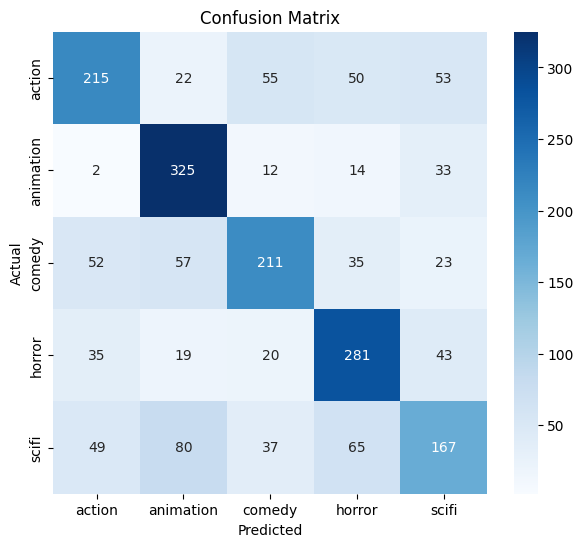

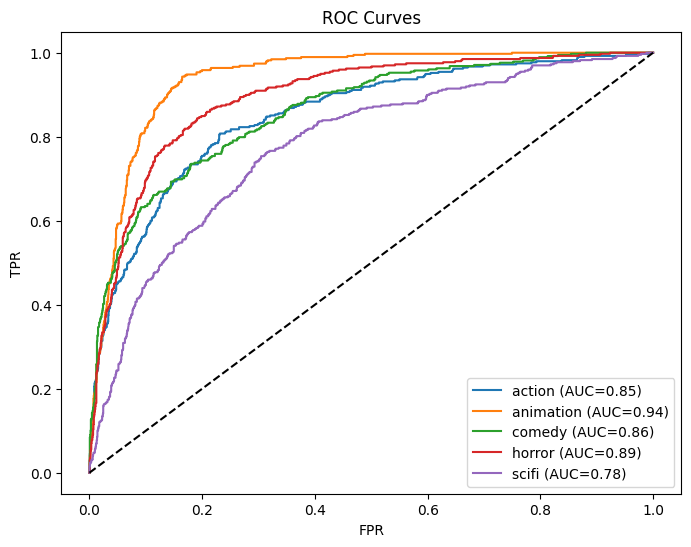

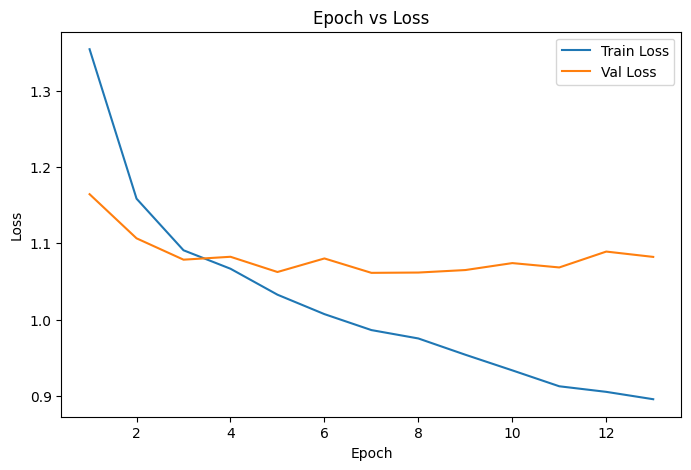

In [ ]:
# ─── 6️⃣ LOAD BEST MODEL & FINAL TEST EVALUATION ────────────────────────────────
model.load_state_dict(torch.load("best_swin_model.pth"))
model.eval()

all_labels, all_preds, all_probs = [], [], []
t_inf = time.time()
with torch.no_grad():
    for imgs, lbls in tqdm(test_loader, desc="Test Inference"):
        imgs = imgs.to(DEVICE)
        out  = model(imgs)
        probs = torch.softmax(out, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)
        all_probs.extend(probs)
        all_preds.extend(preds)
        all_labels.extend(lbls.numpy())
inf_time = time.time() - t_inf

all_labels = np.array(all_labels)
all_preds  = np.array(all_preds)
all_probs  = np.array(all_probs)

# ─── 7️⃣ METRICS ───────────────────────────────────────────────────────────────
conf = confusion_matrix(all_labels, all_preds)
acc   = accuracy_score(all_labels, all_preds)
prec  = precision_score(all_labels, all_preds, average='macro')
rec   = recall_score(all_labels, all_preds, average='macro')
f1    = f1_score(all_labels, all_preds, average='macro')
auc_m = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='micro')
auc_M = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='macro')

# Specificity (macro)
specs = []
for i in range(NUM_CLASSES):
    TP = conf[i,i]
    FN = conf[i,:].sum() - TP
    FP = conf[:,i].sum() - TP
    TN = conf.sum() - TP - FN - FP
    specs.append(TN / (TN + FP))
spec_macro = np.mean(specs)

print(f"\nFinal Test Metrics:")
print(f" • Accuracy       : {acc:.4f}")
print(f" • Precision (M)  : {prec:.4f}")
print(f" • Recall    (M)  : {rec:.4f}")
print(f" • F1-Score  (M)  : {f1:.4f}")
print(f" • AUC-micro      : {auc_m:.4f}")
print(f" • AUC-macro      : {auc_M:.4f}")
print(f" • Sensitivity (M): {rec:.4f}")
print(f" • Specificity (M): {spec_macro:.4f}")
print(f" • Train Time     : {(time.time()-t0):.1f}s")
print(f" • Inference Time : {inf_time:.1f}s")

# ─── 8️⃣ PLOTS ───────────────────────────────────────────────────────────────
plt.figure(figsize=(7,6))
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_ds.classes, yticklabels=test_ds.classes)
plt.title("Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.show()

plt.figure(figsize=(8,6))
fpr, tpr, roc_auc = {}, {}, {}
for i, cls in enumerate(test_ds.classes):
    fpr[i], tpr[i], _ = roc_curve((all_labels==i).astype(int), all_probs[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"{cls} (AUC={roc_auc[i]:.2f})")
plt.plot([0,1],[0,1],'k--'); plt.title("ROC Curves"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1),   val_losses,   label='Val Loss')
plt.title("Epoch vs Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

In [ ]:
# 1️⃣1️⃣ Model Kaydetme
save_path = "swin_model.pth"
torch.save(model.state_dict(), save_path)
print(f"\n✅ Model kaydedildi: {save_path}")